# Cell 1: Import

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import os

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91932\AppData\Roaming\nltk_data...


# Cell 2: Load Data

In [2]:
df = pd.read_csv('../data/LinkedInJobs_MLDataset.csv')

# Cell 3: Rename Columns to Full Forms

In [3]:
rename_dict = {
    'Co_Nm': 'Company_Name',
    'Co_Pg_Lstd': 'Company_Page_Listed',
    'Emp_Cnt': 'Employee_Count',
    'Flw_Cnt': 'Followers_Count',
    'Job_Ttl': 'Job_Title',
    'Job_Desc': 'Job_Description',
    'Is_Supvsr': 'Is_Supervisor',
    'max_sal': 'Max_Salary',
    'med_sal': 'Median_Salary',
    'min_sal': 'Min_Salary',
    'py_prd': 'Pay_Period',
    'py_lstd': 'Pay_Listed',
    'wrk_typ': 'Work_Type',
    'loc': 'Location',
    'st_code': 'State_Code',
    'is_remote': 'Is_Remote',
    'views': 'Views',
    'app_typ': 'Application_Type',
    'app_is_off': 'Application_Is_Offsite',
    'xp_lvl': 'Experience_Level',
    'domain': 'Domain',
    'has_post_domain': 'Has_Posting_Domain',
    'is_sponsored': 'Is_Sponsored',
    'base_comp': 'Base_Compensation'
}
df = df.rename(columns=rename_dict)
print("Renamed Columns:", df.columns.tolist())

# Save cleaned DF
df.to_csv('../data/cleaned_dataset.csv', index=False)

Renamed Columns: ['Company_Name', 'Company_Page_Listed', 'Employee_Count', 'Followers_Count', 'Job_Title', 'Job_Description', 'Is_Supervisor', 'Max_Salary', 'Median_Salary', 'Min_Salary', 'Pay_Period', 'Pay_Listed', 'Work_Type', 'Location', 'State_Code', 'Is_Remote', 'Views', 'Application_Type', 'Application_Is_Offsite', 'Experience_Level', 'Domain', 'Has_Posting_Domain', 'Is_Sponsored', 'Base_Compensation']


# Cell 4: Simple EDA

In [4]:
print("Shape:", df.shape)
print(df.describe())
print("Median_Salary Distribution:", df['Median_Salary'].value_counts(normalize=True).head())
print("Nulls:", df.isnull().sum())

# Filter invalid salaries
df = df[df['Median_Salary'] > 0].reset_index(drop=True)
print("Filtered Shape:", df.shape)

Shape: (33246, 24)
       Employee_Count  Followers_Count    Max_Salary  Median_Salary  \
count    33246.000000     3.324600e+04  3.324600e+04   3.324600e+04   
mean     15484.558744     5.234364e+05  3.186615e+04   2.749495e+04   
std      62180.953563     2.708736e+06  6.823853e+04   5.790564e+04   
min          0.000000     0.000000e+00  0.000000e+00   0.000000e+00   
25%        148.000000     8.135750e+03  0.000000e+00   0.000000e+00   
50%       1235.000000     3.799650e+04  0.000000e+00   0.000000e+00   
75%       8160.000000     1.680360e+05  9.796750e+01   9.000000e+01   
max     829111.000000     3.188720e+07  1.300000e+06   1.050000e+06   

          Min_Salary     Is_Remote         Views  Is_Sponsored  \
count   33246.000000  33246.000000  33246.000000  33246.000000   
mean    23123.763015      0.144438     45.424592      0.244150   
std     48977.379084      0.351539    126.972720      0.429588   
min         0.000000      0.000000      0.000000      0.000000   
25%        

# Cell 5: Feature Engineering

In [6]:
# Cell 5: Feature Engineering (SAFE & WORKING VERSION)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import numpy as np
import os

nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

print("Starting feature engineering...")

# 1. Clean text
df['Job_Description_Clean'] = df['Job_Description'].fillna("").str.lower()
df['Job_Description_Clean'] = df['Job_Description_Clean'].str.replace(r'[^\w\s]', ' ', regex=True)

# 2. TF-IDF — reduced to 800 features to avoid memory crash
print("Fitting TF-IDF (800 features)...")
tfidf = TfidfVectorizer(
    max_features=800,           # ← reduced from 1000
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2                    # ignore very rare words
)
tfidf_matrix = tfidf.fit_transform(df['Job_Description_Clean'])

print(f"TF-IDF shape: {tfidf_matrix.shape}")

# 3. Add text-based features
df['Description_Length'] = df['Job_Description'].apply(lambda x: len(str(x)))
df['Description_Sentiment'] = df['Job_Description'].apply(
    lambda x: sia.polarity_scores(str(x))['compound']
)

# 4. Encode Experience Level
le_exp = LabelEncoder()
df['Experience_Level_Encoded'] = le_exp.fit_transform(df['Experience_Level'])

# 5. Fill missing numeric values safely
numeric_cols = ['Employee_Count', 'Followers_Count', 'Views']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# 6. Final features for salary model (NO TF-IDF in regression — only metadata)
salary_features = [
    'Employee_Count',
    'Followers_Count',
    'Views',
    'Is_Remote',
    'Experience_Level_Encoded',
    'Description_Length',
    'Description_Sentiment'
]

X_salary = df[salary_features].copy()
y_salary = df['Median_Salary']

print("Salary features ready:", X_salary.shape)

# 7. Save everything needed
os.makedirs('../src/models', exist_ok=True)

# Save salary model inputs
joblib.dump({
    'X': X_salary,
    'y': y_salary,
    'le_exp': le_exp,
    'tfidf': tfidf,
    'df_clean': df[['Job_Title', 'Company_Name', 'Location', 'Median_Salary', 'Is_Remote', 'Job_Description_Clean']]
}, '../src/models/preprocessed_data.pkl')

# Save TF-IDF matrix separately for recommendation (sparse format = low memory)
joblib.dump(tfidf_matrix, '../src/models/tfidf_matrix_sparse.pkl')

print("All features saved successfully!")
print("You can now run Cell 6 for training.")

Starting feature engineering...
Fitting TF-IDF (800 features)...
TF-IDF shape: (13350, 800)
Salary features ready: (13350, 7)
All features saved successfully!
You can now run Cell 6 for training.


# Cell 6: Train Salary Model (SIMPLE & FAST)

In [7]:
# Cell 6: Train Salary Model (SIMPLE & FAST)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import joblib

# Load preprocessed data
data = joblib.load('../src/models/preprocessed_data.pkl')
X = data['X']
y = data['y']
le_exp = data['le_exp']
tfidf_matrix = joblib.load('../src/models/tfidf_matrix_sparse.pkl')
df_clean = data['df_clean']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Save final model
joblib.dump({
    'salary_model': model,
    'tfidf_vectorizer': tfidf,
    'label_encoder_exp': le_exp,
    'job_database': df_clean,
    'tfidf_matrix': tfidf_matrix
}, '../src/models/final_model.pkl')

print("Model trained and saved as final_model.pkl")

Model trained and saved as final_model.pkl


# Cell 7: Evaluation - Salary Prediction

SALARY PREDICTION RESULTS
Mean Absolute Error (MAE)   : $40,228
Root Mean Squared Error     : $55,411
R² Score                    : 0.400
Average actual salary       : $67,300


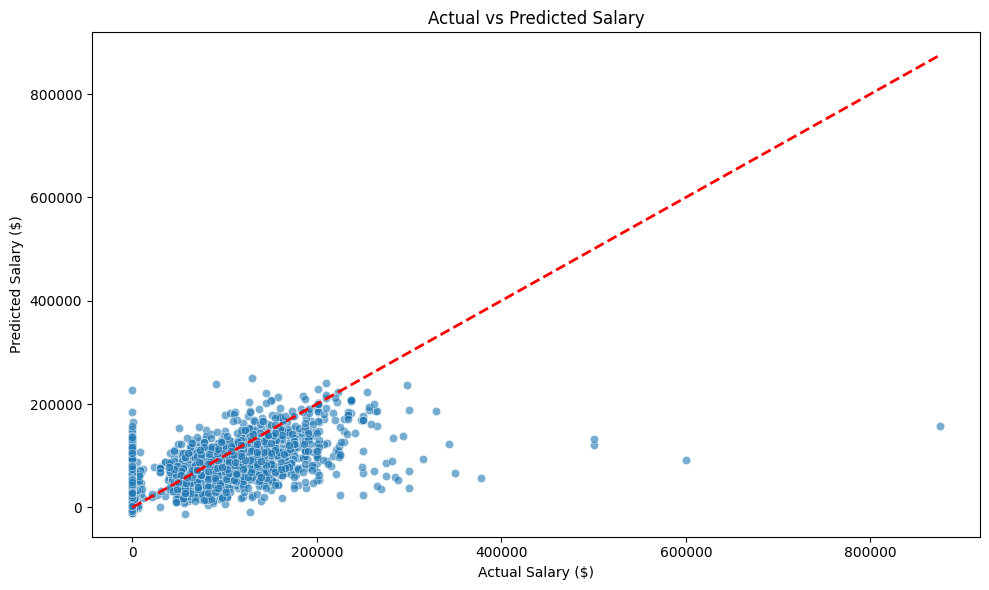


Top 7 Most Important Features:
Experience_Level_Encoded    0.280814
Is_Remote                   0.255551
Views                       0.122185
Followers_Count             0.107981
Description_Length          0.091626
Employee_Count              0.079396
Description_Sentiment       0.062446
dtype: float32


In [8]:
# Cell 7: Evaluation - Salary Prediction
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
bundle = joblib.load('../src/models/final_model.pkl')
model = bundle['salary_model']

# Split again (same random state)
data = joblib.load('../src/models/preprocessed_data.pkl')
X = data['X']
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("SALARY PREDICTION RESULTS")
print("="*50)
print(f"Mean Absolute Error (MAE)   : ${mae:,.0f}")
print(f"Root Mean Squared Error     : ${rmse:,.0f}")
print(f"R² Score                    : {r2:.3f}")
print(f"Average actual salary       : ${y_test.mean():,.0f}")

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Salary ($)")
plt.ylabel("Predicted Salary ($)")
plt.title("Actual vs Predicted Salary")
plt.tight_layout()
plt.show()

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 7 Most Important Features:")
print(importances.head(7))

# Cell 8: Test Recommendation System (No Streamlit yet)

In [9]:
# Cell 8: Test Recommendation System (No Streamlit yet)
from sklearn.metrics.pairwise import cosine_similarity

bundle = joblib.load('../src/models/final_model.pkl')
tfidf = bundle['tfidf_vectorizer']
tfidf_matrix = bundle['tfidf_matrix']
job_db = bundle['job_database']

def recommend_jobs(user_text, top_n=5):
    clean_text = user_text.lower()
    clean_text = __import__('re').sub(r'[^\w\s]', ' ', clean_text)
    user_vec = tfidf.transform([clean_text])
    similarities = cosine_similarity(user_vec, tfidf_matrix).flatten()
    top_idx = similarities.argsort()[-top_n:][::-1]
    results = job_db.iloc[top_idx].copy()
    results['Similarity_Score'] = similarities[top_idx]
    return results.reset_index(drop=True)

# Test it!
test_query = "Senior Python Developer with machine learning experience, remote OK, good salary"
recommendations = recommend_jobs(test_query)

print("YOUR RECOMMENDATIONS")
print("="*80)
for i, row in recommendations.iterrows():
    print(f"{i+1}. {row['Job_Title']} at {row['Company_Name']}")
    print(f"   Salary: ${row['Median_Salary']:,.0f} | Remote: {'Yes' if row['Is_Remote'] else 'No'}")
    print(f"   Match: {row['Similarity_Score']:.1%}\n")

YOUR RECOMMENDATIONS
1. Machine Learning Engineer - $175k+ at Henderson Harbor Group
   Salary: $175,000 | Remote: No
   Match: 40.8%

2. Senior NodeJS Developer at Piper Companies
   Salary: $132,500 | Remote: Yes
   Match: 35.6%

3. Senior Technical Designer at Steve Madden
   Salary: $100 | Remote: No
   Match: 34.6%

4. Director, Machine Learning Platform at Storm3
   Salary: $250,000 | Remote: Yes
   Match: 34.4%

5. Instructional Designer at Solugenix
   Salary: $30 | Remote: Yes
   Match: 34.0%

